# Visual Search with AWS DeepLens
_**Using AWS DeepLens to find visually similar items**_

---

---


## Contents

1. [Background](#Background)
1. [MXNet Model Preparation](#MXNet-Model-Preparation)
1. [Feature Vector Generation](#Feature-Vector-Generation)
1. [Test Queries](#Test-Queries)
1. [Export the Feature Vectors](#Export-the-Feature-Vectors)


## Background

This notebook contains code to help build a visual search engine. After an AWS DeepLens device is shown an item, the device’s deep learning model output is used to populate a list of the top visually similar items. Visual search is the central component of an interface where instead of asking for something by voice or text, you show what you are looking for.

In brief, when shown an item, the DeepLens device generates a “feature vector”, and a Search Lambda function then compares the incoming feature vector of that item to a data store of reference item feature vectors. The Search Lambda function returns the top visually similar reference item matches, which are then consumed by a web app via an API Lambda function fronted by API Gateway.

In this notebook, we'll first prepare a model in MXNet for generating feature vectors, then generate some feature vectors from a test data set.  Next, we'll explore using some test image queries and visualizing the results.  Finally, we'll export the feature vectors generated from a test data set into JSON format so they can be imported to DynamoDB for consumption by the Search Lambda function.


## MXNet Model Preparation <a class="anchor" id="MXNet-Model-Preparation"></a>

To prepare the model, we'll first import a pretrained model from the MXNet Model Zoo.  Then we'll get a reference to the first fully connected layer of the model after the convolutional layers.  We'll use that layer to generate feature vectors of shape (1, 2048).  Accordingly, we'll save a new version of the model with that layer as the output.  

In [1]:
import mxnet as mx
path='http://data.mxnet.io/models/imagenet-11k/'
[mx.test_utils.download(path+'resnet-152/resnet-152-symbol.json'),
 mx.test_utils.download(path+'resnet-152/resnet-152-0000.params'),
 mx.test_utils.download(path+'synset.txt')]

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


['resnet-152-symbol.json', 'resnet-152-0000.params', 'synset.txt']

In [2]:
sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-152', 0)
mod = mx.mod.Module(symbol=sym, context=mx.cpu(), label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)
with open('synset.txt', 'r') as f:
    labels = [l.rstrip() for l in f]

In [3]:
all_layers = sym.get_internals()

In [4]:
fe_sym = all_layers['flatten0_output']
fe_mod = mx.mod.Module(symbol=fe_sym, context=mx.cpu(), label_names=None)
fe_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
fe_mod.set_params(arg_params, aux_params)

In [5]:
# save new model with output layer = flatten0
fe_mod.save_checkpoint('featurizer-v1', 0)

---
## Feature Vector Generation <a class="anchor" id="Feature-Vector-Generation"></a>

For purposes of this notebook, a data set is specified in a text file containing comma-separated (product_title, image_url) tuples.  The following code loops over the tuples specified in the file and creates a list of products ready for feature generation, which involves sending each image through the model and obtaining the 2048-element vector output.

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
# define a simple data batch
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def get_image(fname, show=False):
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    if img is None:
         return None
    if show:
         plt.imshow(img)
         plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
    return img


In [7]:
# preprocessing steps
# data is in text file where each line is csv w/ 2 fields:  product title, image url
# in for loop:
#  read each line
#  download image
#  featurize it
#  normalize it
#  add to dict:  key is index, val is object of the form
#  {"productTitle": ___, "imageUrl": ___, "imageFileName": ___, features": __ }

#  to send to ddb, see features_to_ddb.py script


def process_file(file_name, start_index):
    products = []
    index = start_index
    with open(file_name) as file:
        for line in file:
            product = {}
            fields = line.split(',')
            product['id'] = str(index)
            product['productTitle'] = fields[0].strip()
            product['imageUrl'] = fields[1].strip()
            # download image to be featurized and preprocess it
            file = mx.test_utils.download(product['imageUrl'])
            product['imageFileName'] = file
            img = get_image(file)
            # extract features
            fe_mod.forward(Batch([mx.nd.array(img)]))
            features = fe_mod.get_outputs()[0].asnumpy()
            # normalize and insert in product dict
            norm = np.linalg.norm(features)
            features_normalized = features/norm
            product['features'] = features_normalized
            products.append(product)
            index += 1
    return products

---
## Test Queries <a class="anchor" id="Test-Queries"></a>

For test purposes, we'll pull in images from a small test data set, featurize them, and run some test queries as a sanity check.  We'll compare the query results to the query image (the image on the left), then examine the data set to qualitatively assess how well the model performed.  

In [8]:
products = process_file('monkey-data.txt', 1)

In [9]:
# keep a priority queue of largest cosine similarity
from queue import PriorityQueue
 
q = PriorityQueue(maxsize=3)

def checkHeap(queue, num):
    if not q.full():
        q.put(num)
        return
    top = q.get()
    if num > top:
        q.put(num)
    else:
        q.put(top)
    return

In [10]:
# run test queries
query_id = '1'  
query_object = next((item for item in products if item['id'] == query_id))
for product in products:
    if product['id'] == query_id:
        continue
    cosine = np.vdot(product['features'], query_object['features'])
    checkHeap(q, (cosine, product))

In [11]:
top3 = []
while not q.empty():
    top3.append(q.get())
top3.reverse() # in place

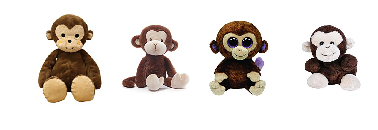

In [12]:
fig = plt.figure()
fig.add_subplot(1,4,1)
img = cv2.cvtColor(cv2.imread(query_object['imageFileName']), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
for index, item in enumerate(top3):
    product = item[1]
    img = cv2.cvtColor(cv2.imread(product['imageFileName']), cv2.COLOR_BGR2RGB)
    fig.add_subplot(1,4,index+2)
    plt.imshow(img)
    plt.axis('off')

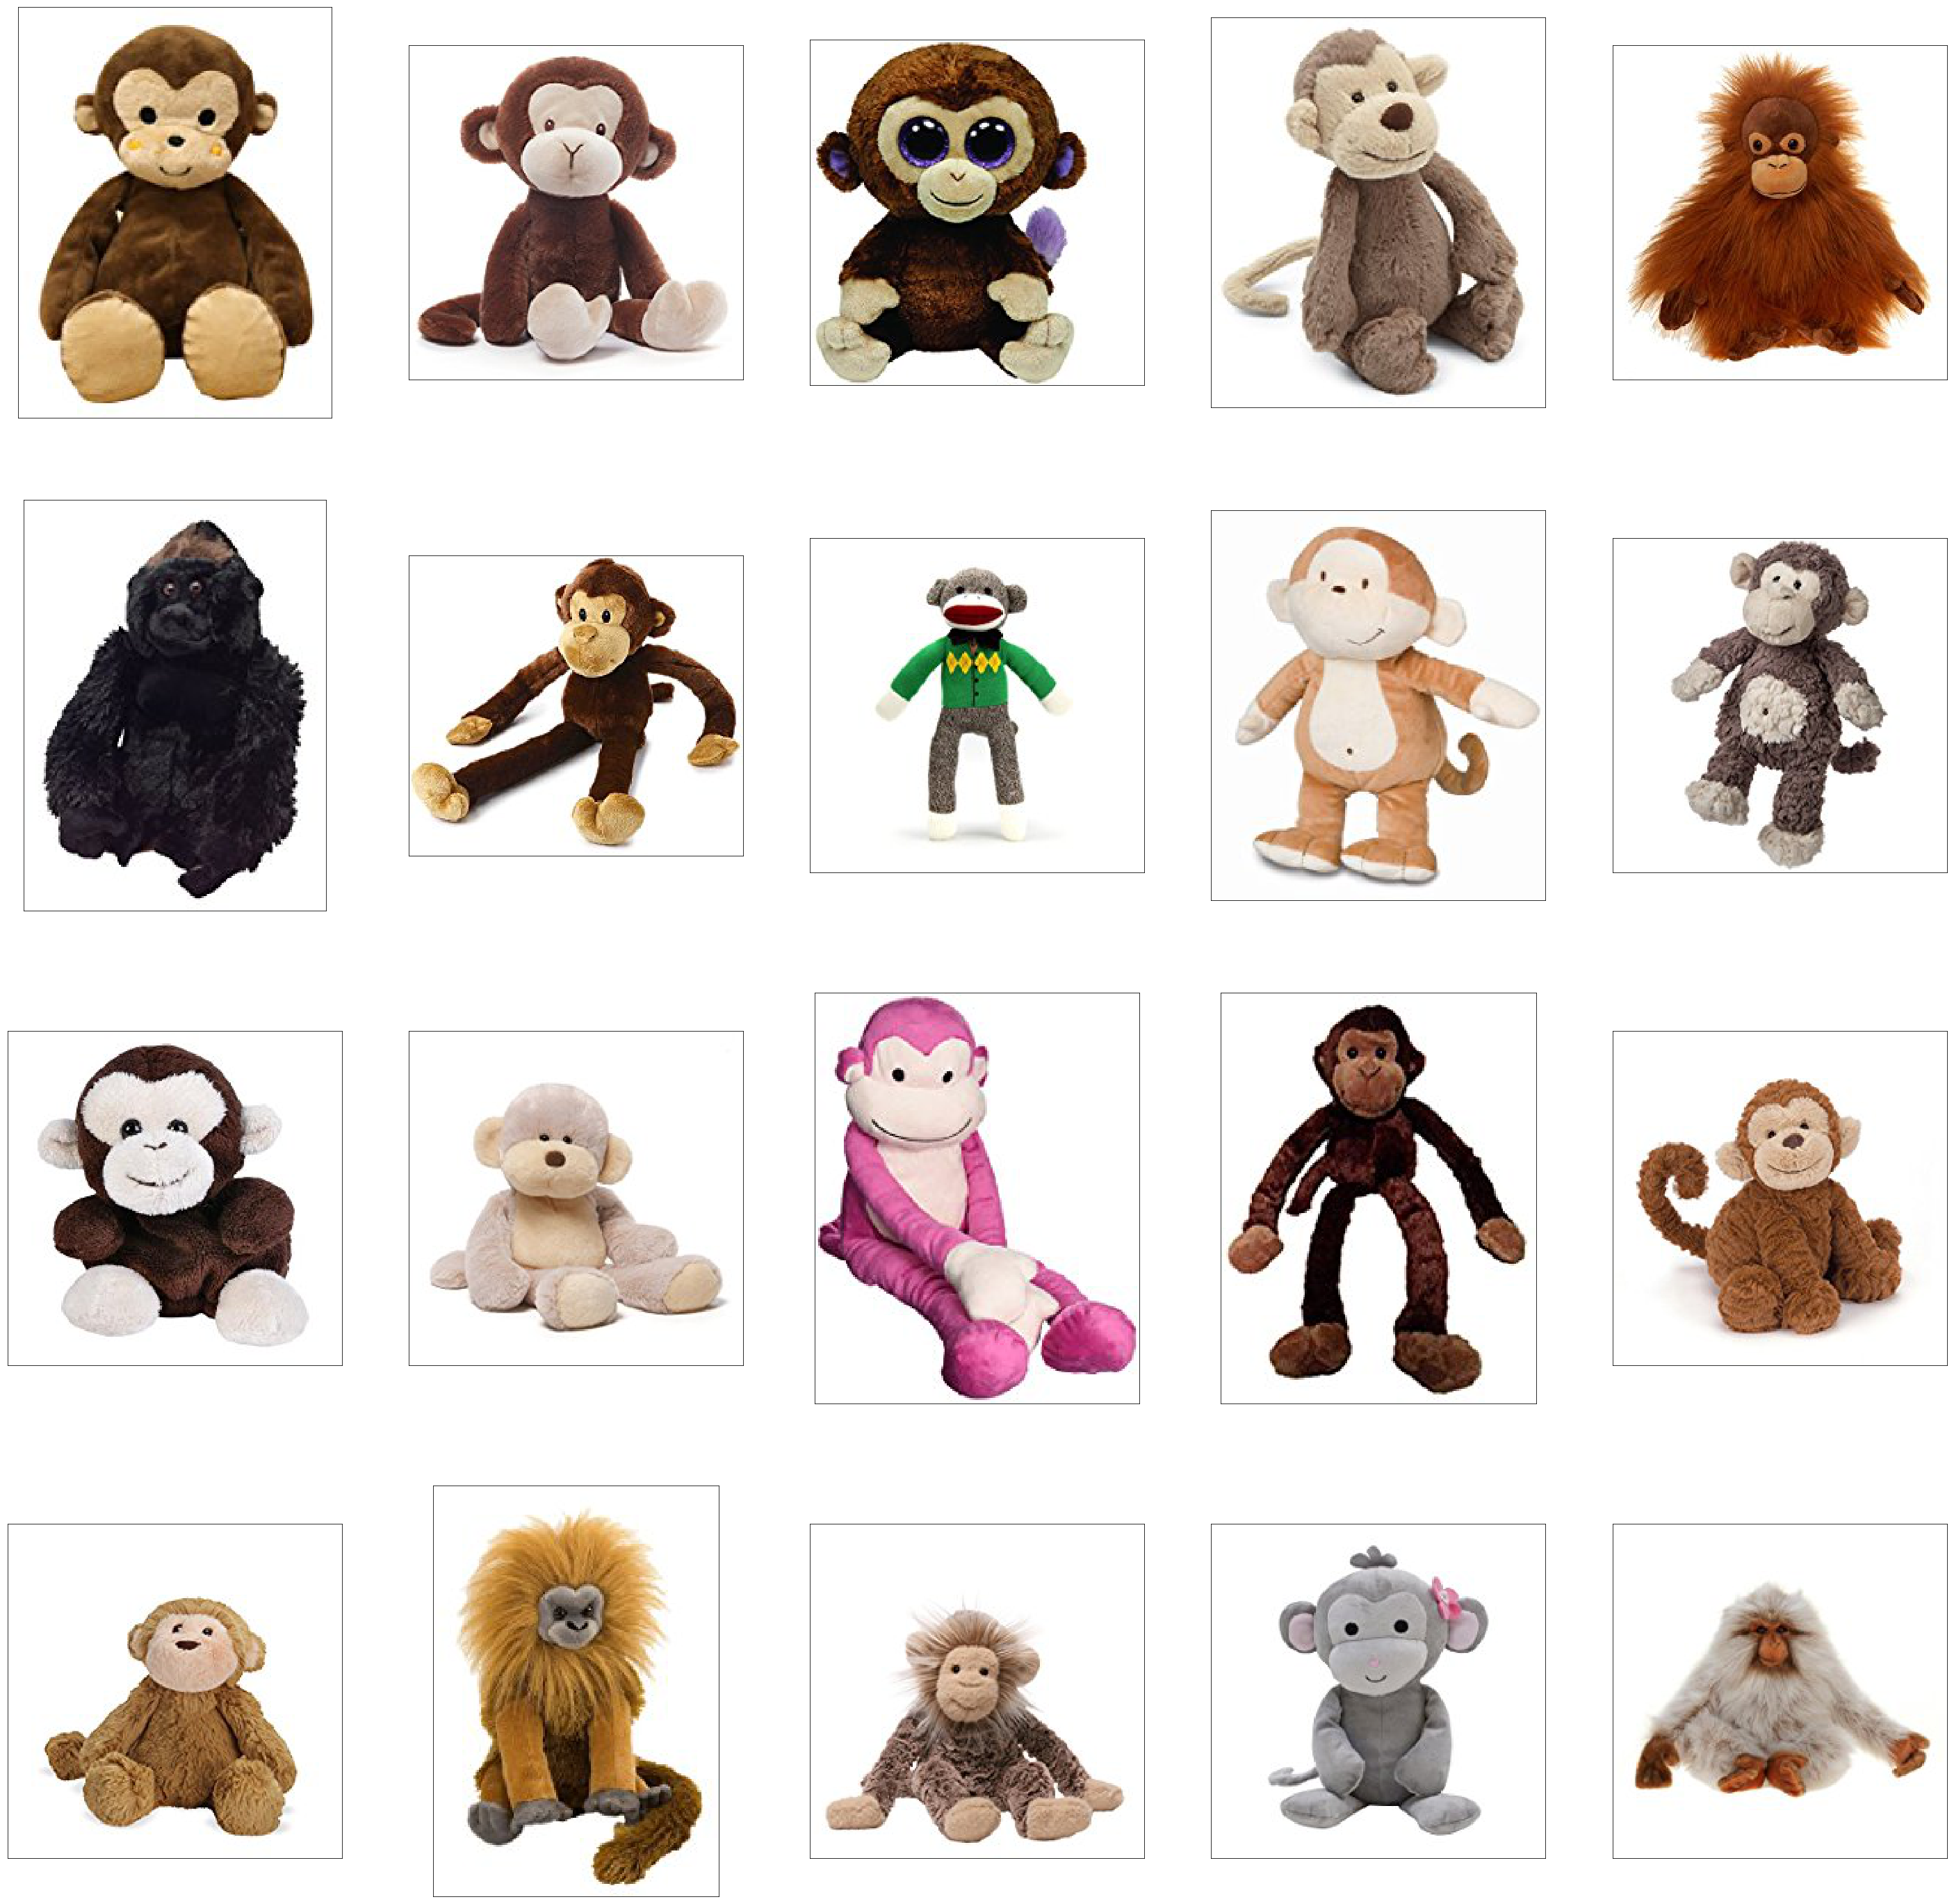

In [13]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(4, 5)

index = 0
for g in gs:
    img_file = products[index]['imageFileName'] 
    _img = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)
    ax = plt.subplot(g)
    ax.imshow(_img)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_aspect('auto')
    index += 1

fig = plt.gcf()
fig.set_size_inches(50, 50, forward=True)

---
## Export the Feature Vectors <a class="anchor" id="Export-the-Feature-Vectors"></a>

We're now ready to export the feature vectors.  To do so, we'll simply extract the relevant metadata, and convert the feature vector to a string containing comma-separated elements.  Then we'll write the results out in JSON format to a file.  You can then make use of the feature vectors, for example by using the script features_to_ddb.py to import them to DynamoDB for use by the Search Lambda function.

In [14]:
# converting from numpy to python list, store file

import json 

records = []
for product in products:
    record = {}
    record['id'] = product['id']
    record['title'] = product['productTitle']
    record['url'] = product['imageUrl']
    py_array = product['features'].tolist()
    row = py_array[0]
    conv = ','.join(str(e) for e in row)
    record['features'] = conv
    records.append(record)
    
with open("features.json", "w") as f:
    f.write(json.dumps(records))